# Adaptive PDE discretizations on cartesian grids 
## Volume : GPU accelerated methods
## Part : High dimensional problems
## Chapter : Minimal paths for a rolling ball

In this notebook, we solve the eikonal equation for a family of optimal control models involving balls, whose analytical models are described in a [previous notebook](RollingBall_Models.ipynb). Let us recall that 
* The state of a ball is determined by three rotation parameters.
* The ball may be placed on line, or on a plane, thus adding one or two parameters to the state space.

We are thus solving sub-Riemannian models in dimension three to five. Depending on the case, they have sub-Riemannian rank (zero,) one or two.

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"../..")
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Trailers','GPU'))

In [2]:
from agd import Eikonal
from agd import AutomaticDifferentiation as ad
from agd import Metrics
from agd import LinearParallel as lp
from agd.Interpolation import map_coordinates

In [3]:
from agd.ExportedCode.Notebooks_Algo import RollingBall_Models

In [4]:
import numpy as np; xp=np; allclose = np.allclose
from matplotlib import pyplot as plt
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%5.3g" % x))

In [5]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global Eikonal,ad,cugen,allclose
    Eikonal,ad,cugen,allclose = rreload([Eikonal,ad,cugen,allclose],"..")
    Eikonal.dictIn.default_mode = 'gpu'

### 0.1 Additional configuration

The experiments presented in this notebook require the GPU accelerated solver. 
(Adapting them for the cpu solver would not be too difficult, although computation times would be longer.)

In [6]:
if ad.cupy_generic.cp is None: raise ad.DeliberateNotebookError("cupy module not found")

In [7]:
xp,Eikonal,plt,allclose = [ad.cupy_friendly(e) for e in (xp,Eikonal,plt,allclose)]

Replacing numpy with cupy, set to output 32bit ints and floats by default.
Using cp.asarray(*,dtype=np.float32) as the default caster in ad.array.
Setting dictIn.default_mode = 'gpu' in module agd.Eikonal .
Returning a copy of module matplotlib.pyplot whose functions accept cupy arrays as input.
Setting float32 compatible default values atol=rtol=1e-5 in np.allclose


## 1. Ball models

We consider three dimensional Riemannian and sub-Riemannian models, corresponding to a ball whose rotation can be controlled over three axes, or only two of them. 

### 1.1 Two dimensional projective sphere

As a starter, we compute geodesics on the projective plane. In other words the two dimensional sphere whose north and south hemispheres are identified and glued around the equator. 

**Motivation.** The state of a two dimensional ball is described by a three dimensional rotation, which can be parametrized by the three dimensional projective space, via the quaternionic unit projective sphere.

**Parametrization of the projective plane.**
We parametrize the unit sphere (minus the south pole) from the equator plane, using a standard stereographic projection $R^d \to S^d \setminus \{(-1,0,\ldots,0)\}$
$$
    e \mapsto \frac {(1-\|e\|^2,2 e)}{1+\|e\|^2}
$$
Thsi is also the approach developed in the rolling balls notebook.

In [8]:
plane_to_sphere = RollingBall_Models.quaternion_from_euclidean
sphere_to_plane = RollingBall_Models.euclidean_from_quaternion

The projective plane is obtained by identifying opposite points of the unit sphere. Using our coordinate chart, this amounts to the following glue map.

In [9]:
def glue(x): 
    """
    Glue map for the projective plane, as parameterized from the equator.
    (Maps a point to the other point with which it identifies.)
    """    
    return sphere_to_plane( - plane_to_sphere(x))

In [10]:
for x in [(1,1),(1,0),(0,0)]:
    print(f"Parametrization point {x} identifies with {glue(x)}")

Parametrization point (1, 1) identifies with [ -0.5  -0.5]
Parametrization point (1, 0) identifies with [   -1    -0]
Parametrization point (0, 0) identifies with [  nan   nan]


We pull back the metric of the unit ball onto the equator plane.

In [11]:
def metric(x):
    """
    Pulls back the Euclidean metric on the sphere onto the plane.
    """
    x_ad = ad.Dense.identity(constant=x,shape_free=(len(x),))
    Jac = np.moveaxis(plane_to_sphere(x_ad).gradient(),0,1)
    return lp.dot_AA(lp.transpose(Jac),Jac)

In [12]:
metric([1.2,0])

array([[0.672,     0],
       [    0, 0.672]], dtype=float32)

It turns out that this metric is isotropic, a well known property of the stereographic projection. We may thus content ouserlves with a cost function:
$$
    m(x) = c(x)^2 \mathrm{Id}.
$$
The exact value of the conformal cost $c$ associated with the stereographic projection is known explicitly, namely
$$
    c(x) = \frac 2 {\sqrt{1+\|x\|^2}},
$$
but for this computation is not even needed.

<!---, and thus it is left as an exercise for the interested reader.--->

In [13]:
def cost(x):
    """
    Cost function associated with the conformal metric of the stereographic projection.
    """
    return np.sqrt(metric(x)[0,0]) # Alternatively, use the explicit expression 2/sqrt(1+ |x|^2)

We are now prepared to run the fast marching method.

In [14]:
hfmIn = Eikonal.dictIn({
    'model':'Isotropic2',
    'seed':[0.5,0.7],
    'exportValues':True,
    'factoringRadius':10,
})
r=1.1
hfmIn.SetRect([[-r,r],[-r,r]],dimx=101)
X = hfmIn.Grid()

hfmIn['cost']=cost(X)
hfmIn.SetUniformTips((4,4))

In [15]:
hfmOut = hfmIn.Run()

NameError: name '_Chart' is not defined

So far, we havent applied the glue boundary condition. Hence the values and the glued values have no reason to match.

C:\Users\Shadow\Miniconda3\envs\agd-hfm_cuda\lib\site-packages\cupyx\scipy\ndimage\interpolation.py:27: UserWarning: In the current feature the default order of map_coordinates is 1. It is different from scipy.ndimage and can change in the future.
  'the future.'.format(func_name))


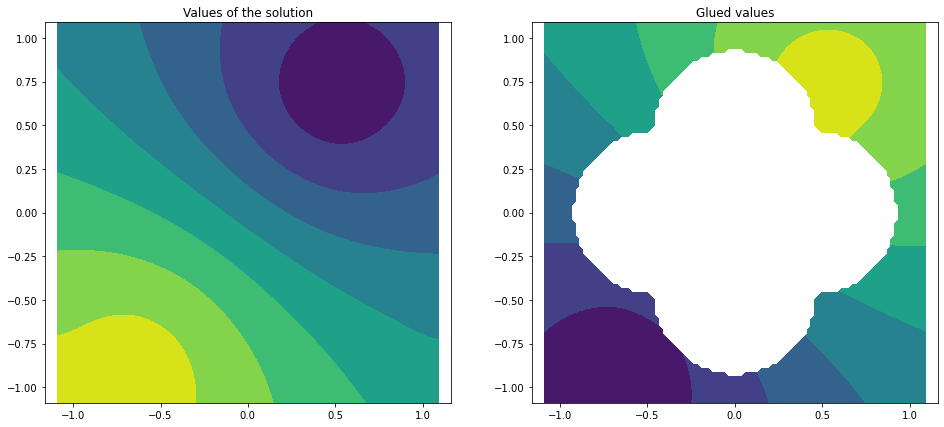

In [16]:
values = hfmOut['values']
glued_values = map_coordinates(values,glue(X),grid=X,cval=np.inf)

plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
plt.title('Values of the solution')
plt.contourf(*X,values) 
plt.axis('equal')

plt.subplot(1,2,2)
plt.title('Glued values')
plt.contourf(*X,glued_values) 
plt.axis('equal');

The following function runs the fast marching method `niter`  times, applying the glue boundary conditions each time. After enough iterations, only two in our case, the solution obeying the precribed boundary conditions is obtained.

In [17]:
def run_with_glue(hfmIn, glue, niter):
    hfmOut = hfmIn.Run() # Initial run

    hfmIn = hfmIn.copy() 
    for key in ['factoringRadius','seed']: hfmIn.pop(key)
    X = hfmIn.Grid()
    glueX = glue(X)
    
    for i in range(niter-1):
        values = hfmOut['values']
        glued_values = map_coordinates(values,glueX,grid=X,cval=np.inf)
        hfmIn.update({
            'values':np.minimum(values,glued_values), # Initial guess 
            'trigger':glued_values < values, # Where to start the front
        })
        if not np.any(hfmIn['trigger']): break
        elif hfmIn.get('verbosity',1): print("---- Next glue iter ----")
        hfmOut = hfmIn.Run()
    return hfmIn,hfmOut

In [18]:
hfmIn_glued,hfmOut = run_with_glue(hfmIn,glue,2)

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.006475925445556641 seconds, and 10 iterations.
Post-Processing
---- Next glue iter ----
Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.011986970901489258 seconds, and 5 iterations.
Post-Processing


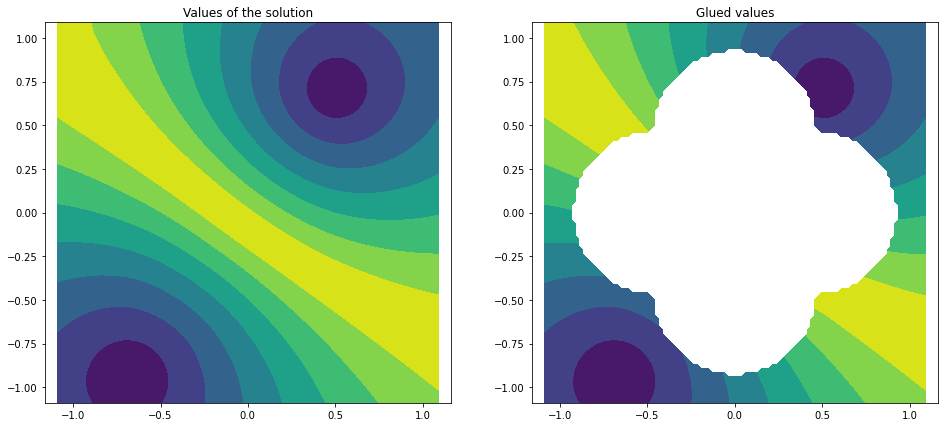

In [19]:
values = hfmOut['values']
glued_values = map_coordinates(values,glue(X),grid=X,cval=np.inf)

plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
plt.title('Values of the solution')
plt.contourf(*X,values) 
plt.axis('equal')

plt.subplot(1,2,2)
plt.title('Glued values')
plt.contourf(*X,glued_values) 
plt.axis('equal');

However, we now face an issue regarding the geodesics, which need to be glued as well.

In [20]:
hfmIn_glued.SetUniformTips((4,4))
hfmOut = hfmIn_glued.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.003999471664428711 seconds, and 5 iterations.
Post-Processing


The geodesics should jump according to the gluing map when they leave the reference domain. This is especially important when a geodesic reaches the boundary, in which case it gets erroneous information.

* Issue : one geodesic stops early because of the past-seed criterion, because it uses an incorrect seed info. (Trigger instead of actual seed.)

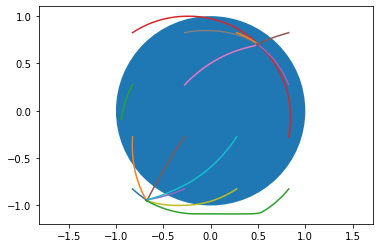

In [21]:
plt.axis('equal')
circle1=plt.Circle((0,0),1.)
plt.gcf().gca().add_artist(circle1)
for geo in hfmOut['geodesics']: plt.plot(*geo)

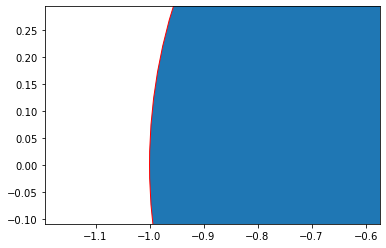

In [31]:
plt.axis('equal')
circle1=plt.Circle((0,0),1.,edgecolor='red',color=None)
plt.gcf().gca().add_artist(circle1)
for geo in hfmOut['geodesics'][2:3]: plt.plot(*geo)

In [32]:
hfmOut['geodesics'][2]

array([[-0.825, -0.828, -0.83, -0.833, -0.835, -0.838, -0.84, -0.843, -0.845, -0.847, -0.85, -0.852, -0.854, -0.857, -0.859, -0.861, -0.863, -0.865, -0.868, -0.87, -0.872, -0.874, -0.876, -0.878, -0.88, -0.882, -0.884, -0.886, -0.888, -0.889, -0.891, -0.893, -0.895, -0.897, -0.898,  -0.9, -0.902, -0.903, -0.905, -0.907, -0.908, -0.91, -0.911, -0.913, -0.914, -0.915, -0.917, -0.918, -0.92, -0.921, -0.922, -0.923, -0.925, -0.926, -0.927, -0.928, -0.929, -0.93, -0.931, -0.932, -0.933, -0.934, -0.935, -0.936, -0.937, -0.938, -0.939, -0.94, -0.94, -0.941, -0.942, -0.942],
       [0.275,  0.27, 0.265, 0.261, 0.256, 0.251, 0.246, 0.241, 0.236, 0.231, 0.226, 0.222, 0.217, 0.212, 0.207, 0.202, 0.197, 0.192, 0.187, 0.182, 0.177, 0.172, 0.167, 0.162, 0.157, 0.151, 0.146, 0.141, 0.136, 0.131, 0.126, 0.121, 0.116,  0.11, 0.105,   0.1, 0.0949, 0.0897, 0.0845, 0.0793, 0.0741, 0.0689, 0.0636, 0.0584, 0.0531, 0.0479, 0.0426, 0.0373, 0.032, 0.0268, 0.0215, 0.0162, 0.0109, 0.00555, 0.000228, -0.0051, -0.

In [22]:
hfmOut['geodesic_stopping_criteria']

['Stationnary',
 'Stationnary',
 'PastSeed',
 'Stationnary',
 'Stationnary',
 'Stationnary',
 'Stationnary',
 'Stationnary',
 'Stationnary',
 'Stationnary',
 'Stationnary',
 'Stationnary',
 'Stationnary',
 'Stationnary',
 'Stationnary',
 'Stationnary']

In [75]:
def geodesics_with_glue(hfmIn,glue,niter):
    hfmIn = hfmIn.copy()
    hfmIn['retself']=True
    hfmOut,interface = hfmIn.Run()
    
    hfmOut['keys']['help'].clear()
    interface.hfmIn.SetUniformTips((2,10))
    interface.GetGeodesics()
    return interface.hfmOut

In [76]:
hfmOut = geodesics_with_glue(hfmIn_glued,glue,2)

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.0035009384155273438 seconds, and 5 iterations.
Post-Processing


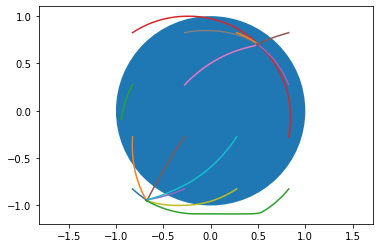

In [77]:
plt.axis('equal')
circle1=plt.Circle((0,0),1.)
plt.gcf().gca().add_artist(circle1)
for geo in hfmOut['geodesics']: plt.plot(*geo)

In [54]:
hfmOut['geodesic_stopping_criteria'] # All rubbish

['Stationnary',
 'Stationnary',
 'PastSeed',
 'Stationnary',
 'Stationnary',
 'Stationnary',
 'Stationnary',
 'Stationnary',
 'Stationnary',
 'Stationnary',
 'Stationnary',
 'Stationnary',
 'Stationnary',
 'Stationnary',
 'Stationnary',
 'Stationnary']

In [53]:
hfmOut.keys()

dict_keys(['keys', 'geodesics', 'geodesic_stopping_criteria', 'values', 'stats', 'solverGPUTime'])

### 1.2 The Riemannian ball